# Generate 9 Small Luminosity Datasets

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import norm, lognorm
import pandas as pd
import numpy as np
import seaborn as sns
import itertools

rc('text', usetex=True)
sns.set_style("whitegrid")

# we will work with datasets of 2000 samples
n = 2000
tmp = pd.read_csv('mock_data.csv')
mass = tmp.mass[0 : n].as_matrix()
z = tmp.z[0 : n].as_matrix()

datasets = []
for seed in xrange(9):
    alpha1 = norm(10.709, 0.022).rvs()
    alpha2 = norm(0.359, 0.009).rvs()
    alpha3 = 2.35e14
    alpha4 = norm(1.10, 0.06).rvs()
    S = norm(0.155, 0.0009).rvs()
    sigma_L = 0.05
    mu_li = np.exp(alpha1) * ((mass / alpha3) ** (alpha2))* ((1+z) ** (alpha4))
    li = lognorm(S, scale=mu_li).rvs()
    observed = lognorm(sigma_L, scale=li).rvs()
    d = {
        'seed': seed,
        'alpha1': alpha1,
        'alpha2': alpha2,
        'alpha3': alpha3,
        'alpha4': alpha4,
        'S': S,
        'sigma_L': sigma_L,
        'lum_mu': mu_li,
        'lum': li,
        'lum_obs': observed,
        'mass': mass,
        'z': z,
    }
    datasets.append(d)


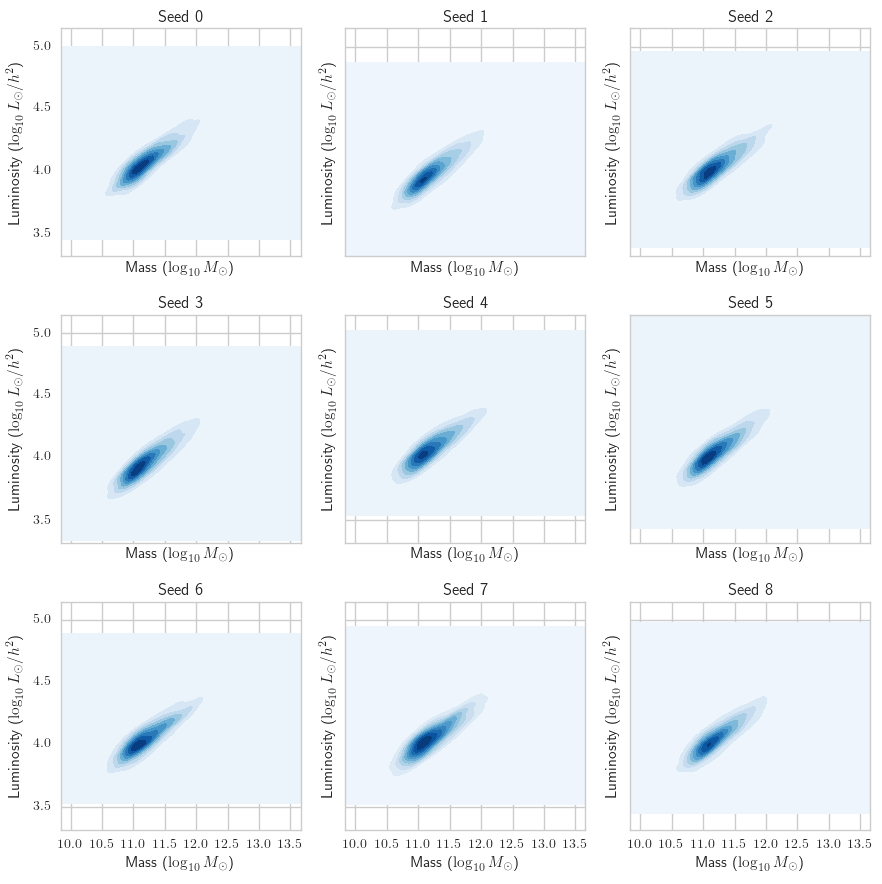

In [2]:
def log10(arr):
    return np.log(arr) / np.log(10)

f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    sns.kdeplot(log10(d['mass']), log10(d['lum']), shade=True, cmap='Blues', ax=ax)
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Luminosity ($\log_{10} L_{\odot} / h^2$)')
    ax.set_title('Seed %d' % i)

f.tight_layout()

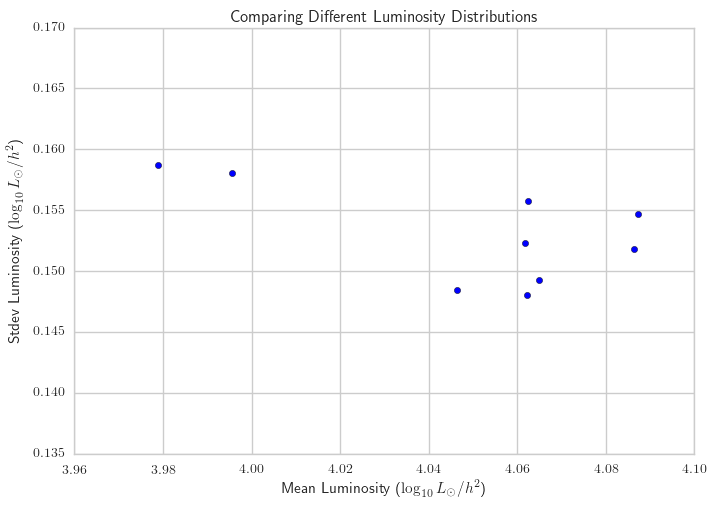

In [3]:
mus = []
stds = []
for i in xrange(9):
    d = datasets[i]
    mus.append(np.mean(log10(d['lum'])))
    stds.append(np.std(log10(d['lum'])))
plt.scatter(mus, stds)
plt.xlabel('Mean Luminosity ($\log_{10} L_{\odot} / h^2$)')
plt.ylabel('Stdev Luminosity ($\log_{10} L_{\odot} / h^2$)')
plt.title('Comparing Different Luminosity Distributions');

# Invert Observed Luminosities

In [4]:
for dataset in datasets:
    dataset['inv_lum'] = lognorm(dataset['sigma_L'], scale=dataset['lum_obs']).rvs()

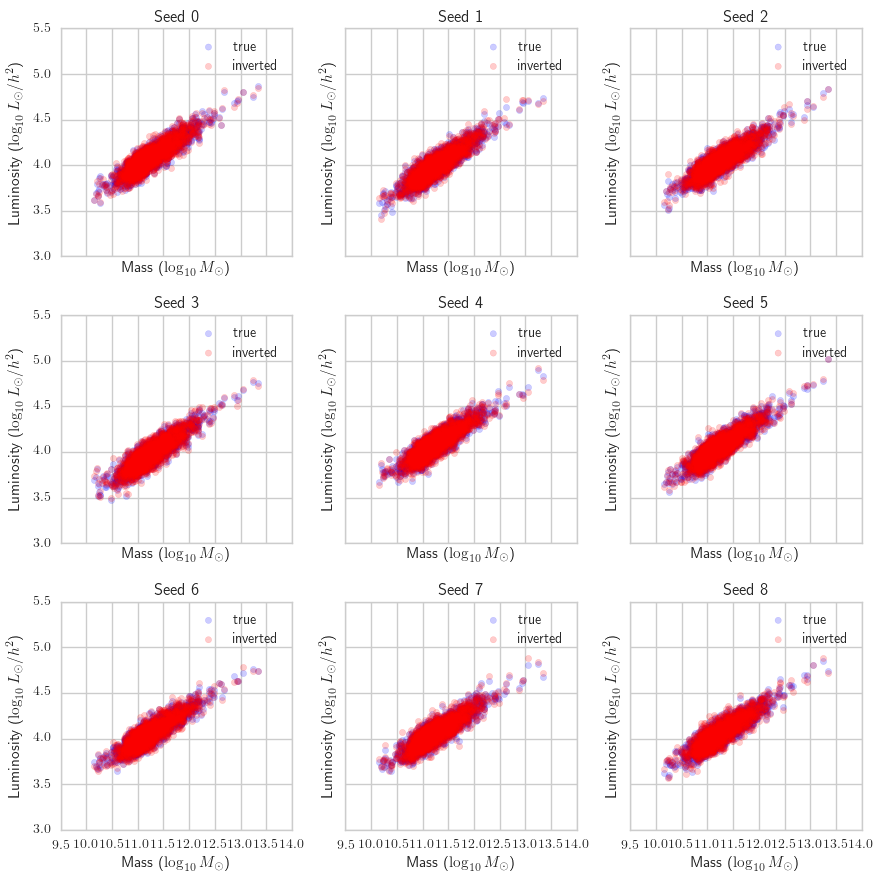

In [5]:
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    ax.scatter(log10(d['mass']), log10(d['lum']), color='blue', alpha=0.2, label='true')
    ax.scatter(log10(d['mass']), log10(d['inv_lum']), color='red', alpha=0.2, label='inverted')
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Luminosity ($\log_{10} L_{\odot} / h^2$)')
    ax.set_title('Seed %d' % i)
    ax.legend()

f.tight_layout()

# Invert Mass

In [6]:
for d in datasets:
    d['inv_mass_mu'] = d['alpha3'] * (d['inv_lum'] / (np.exp(d['alpha1']) * (1 + d['z']) ** d['alpha4'])) ** (1 / d['alpha2'])
    d['inv_mass'] = lognorm(d['S'], scale=d['inv_mass_mu']).rvs()

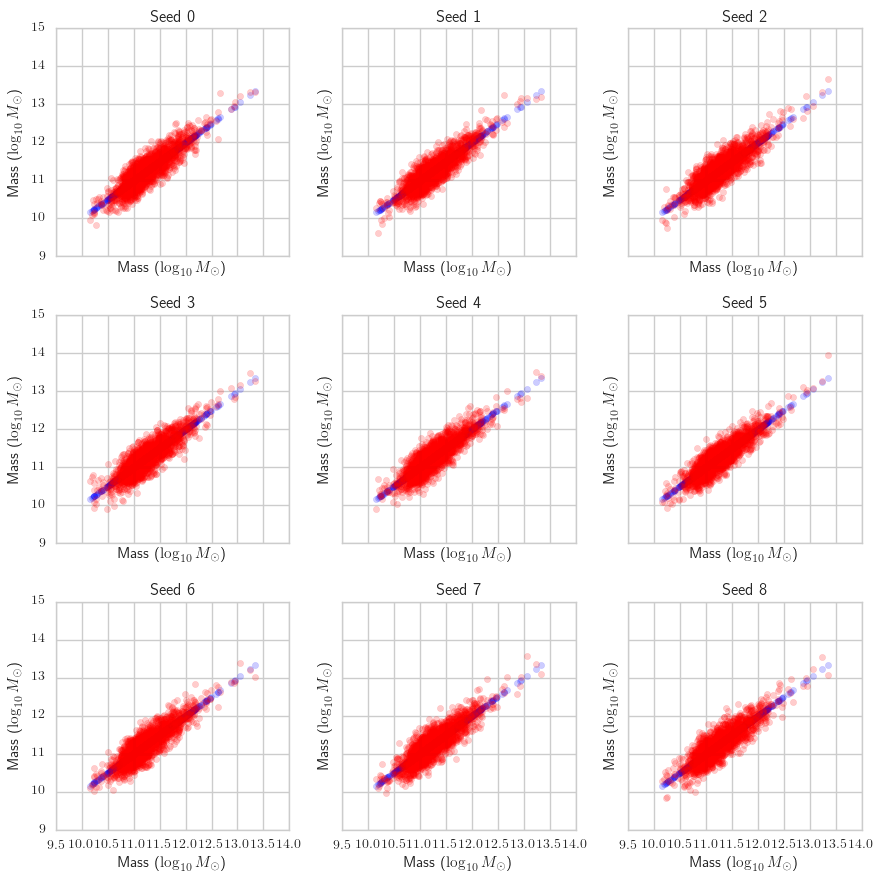

In [7]:
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    ax.scatter(log10(d['mass']), log10(d['mass']), color='blue', alpha=0.2)
    ax.scatter(log10(d['mass']), log10(d['inv_mass']), color='red', alpha=0.2)
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_title('Seed %d' % i)

f.tight_layout()

Now we fix seed0 and compare against to see how sensitive our inversions are to the drawn hyperparameters.

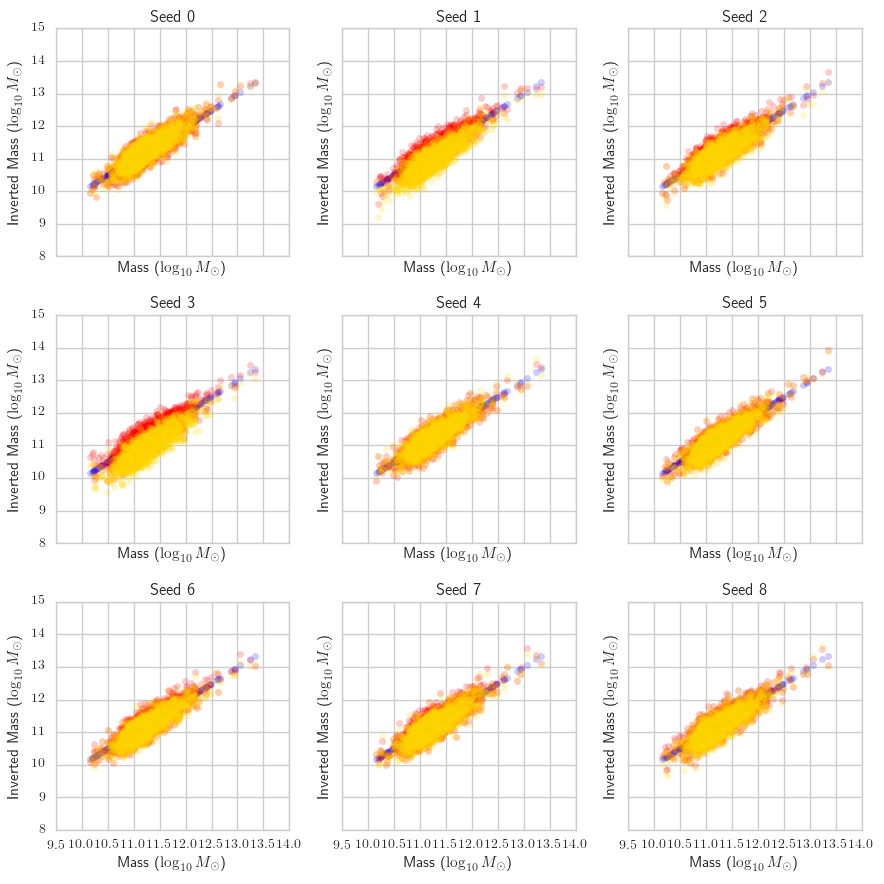

In [8]:
for d in datasets:
    fixed_seed = 0
    alpha1 = datasets[fixed_seed]['alpha1']
    alpha2 = datasets[fixed_seed]['alpha2']
    alpha3 = datasets[fixed_seed]['alpha3']
    alpha4 = datasets[fixed_seed]['alpha4']
    S = datasets[fixed_seed]['S']
    d['seed_inv_mass_mu'] = alpha3 * (d['inv_lum'] / (np.exp(alpha1) * (1 + d['z']) ** alpha4)) ** (1 / alpha2)
    d['seed_inv_mass'] = lognorm(S, scale=d['seed_inv_mass_mu']).rvs()

f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    ax.scatter(log10(d['mass']), log10(d['mass']), color='blue', alpha=0.2)
    ax.scatter(log10(d['mass']), log10(d['inv_mass']), color='red', alpha=0.2)
    ax.scatter(log10(d['mass']), log10(d['seed_inv_mass']), color='gold', alpha=0.2)
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Inverted Mass ($\log_{10} M_{\odot}$)')
    ax.set_title('Seed %d' % i)

f.tight_layout()

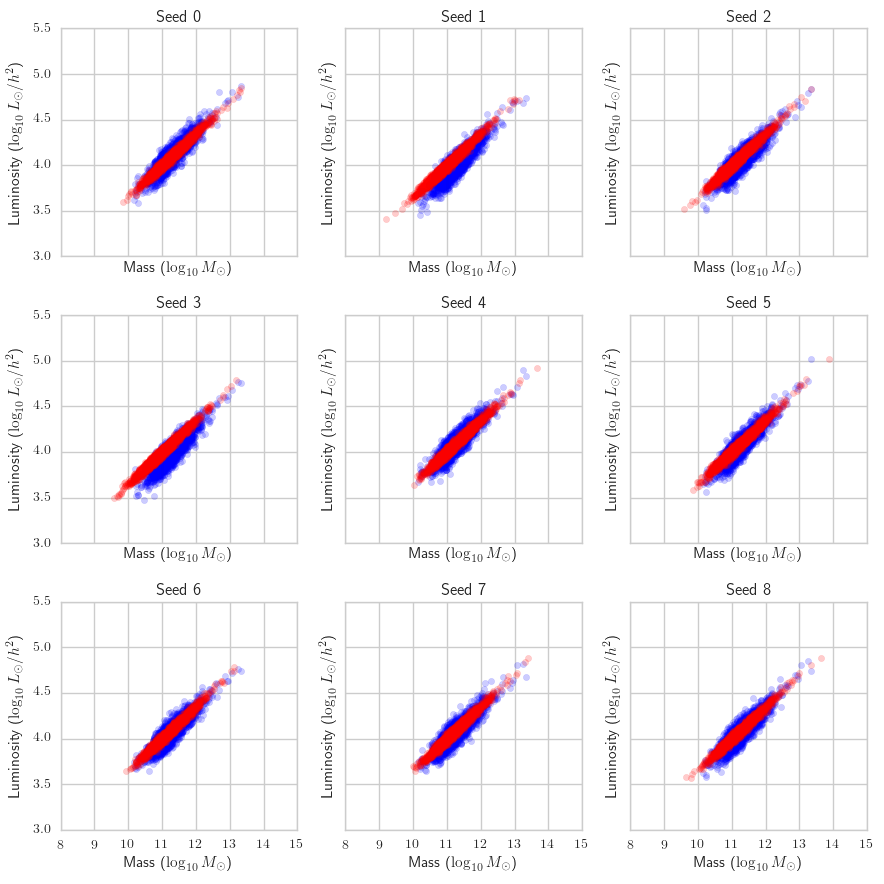

In [9]:
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    ax.scatter(log10(d['mass']), log10(d['lum']), color='blue', alpha=0.2)
    ax.scatter(log10(d['seed_inv_mass']), log10(d['inv_lum']), color='red', alpha=0.2)
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Luminosity ($\log_{10} L_{\odot} / h^2$)')
    ax.set_title('Seed %d' % i)

f.tight_layout()

In [10]:
import hmf
import scipy.interpolate as interpolate

class MassPrior():
    """
    Class to represent mass prior distribution.
    Initialize with mass and probability arrays.
    Can both evaluate and sample from distribution.
    """
    def __init__(self, mass, prob):
        self.mass = mass
        self.prob = prob
        self.min = mass.min()
        self.max = mass.max()
        # have to add 0,1 samples for interpolation bounds
        cumsum = np.append(np.append(np.array([0]), np.cumsum(prob)), np.array([1]))
        masses = np.append(np.append(np.array([self.min-1]), self.mass), np.array([self.max+1]))
        self.inv_cdf = interpolate.interp1d(cumsum, masses)

    def pdf(self, mass):
        ret = self._pdf(mass)
        if (len(mass) > 1):
            ret = np.prod(ret)
        return ret
    
    def logpdf(self, mass):
        ret = np.log(self._pdf(mass))
        if (len(mass) > 1):
            ret = np.sum(ret)
        return ret
        
    def _pdf(self, mass):
        if np.any(mass < self.min) or np.any(mass > self.max):
            raise Exception('out of range')
        right_ind = np.searchsorted(self.mass, mass)
        left_ind = right_ind - 1
        # find where we fall in interval between masses
        f = (mass - self.mass[left_ind]) / (self.mass[right_ind] - self.mass[left_ind])
        return f * self.prob[right_ind] + (1-f) * self.prob[left_ind]
        
    def rvs(self, size=1):
        return self.inv_cdf(np.random.rand(size))
    
    @staticmethod
    def default():
        h = 0.73
        Mmin = 10.2358590918
        Mmax = 14.3277327776
        mf = hmf.MassFunction(Mmin=Mmin, Mmax=Mmax, cosmo_model=hmf.cosmo.WMAP5, hmf_model=hmf.fitting_functions.Tinker10)
        return MassPrior(mf.m*h, mf.dndm / sum(mf.dndm)) # the h normalization is important

mass_prior = MassPrior.default()
samplings = []
for i in xrange(9):
    np.random.seed(i)
    fixed_seed = 0
    alpha1 = datasets[fixed_seed]['alpha1']
    alpha2 = datasets[fixed_seed]['alpha2']
    alpha3 = datasets[fixed_seed]['alpha3']
    alpha4 = datasets[fixed_seed]['alpha4']
    S = datasets[fixed_seed]['S']
    s = dict()
    s['mass'] = mass_prior.rvs(size=n)
    s['lum_mu'] = np.exp(alpha1) * ((s['mass'] / alpha3) ** (alpha2))* ((1+z) ** (alpha4))
    s['lum'] = lognorm(S, scale=s['lum_mu']).rvs()
    s['seed'] = i
    samplings.append(s)

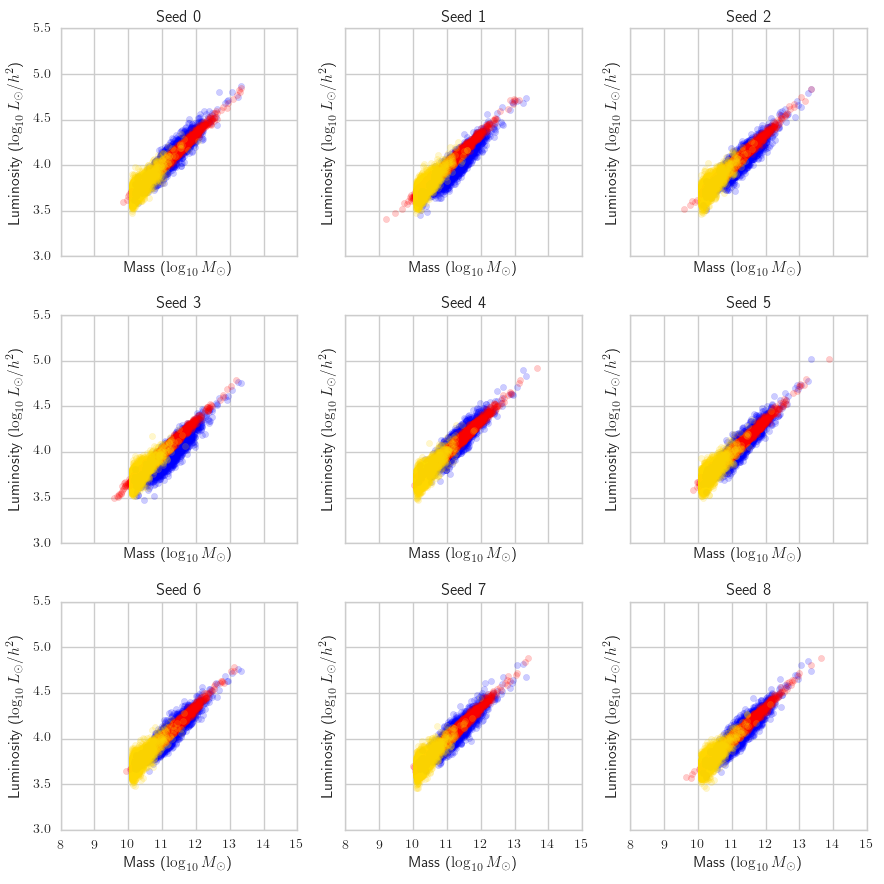

In [11]:
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    s = samplings[i]
    ax.scatter(log10(d['mass']), log10(d['lum']), color='blue', alpha=0.2)
    ax.scatter(log10(d['seed_inv_mass']), log10(d['inv_lum']), color='red', alpha=0.2)
    ax.scatter(log10(s['mass']), log10(s['lum']), color='gold', alpha=0.2)
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Luminosity ($\log_{10} L_{\odot} / h^2$)')
    ax.set_title('Seed %d' % i)

f.tight_layout()

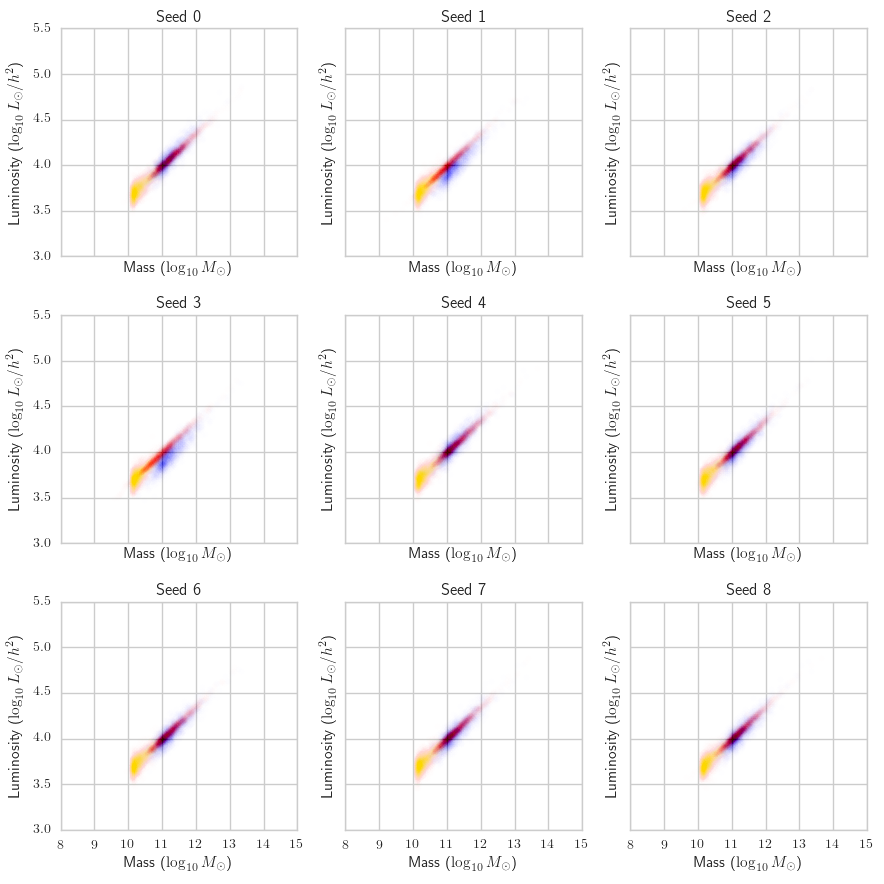

In [12]:
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    s = samplings[i]
    ax.scatter(log10(d['mass']), log10(d['lum']), color='blue', alpha=0.005)
    ax.scatter(log10(d['seed_inv_mass']), log10(d['inv_lum']), color='red', alpha=0.005)
    ax.scatter(log10(s['mass']), log10(s['lum']), color='gold', alpha=0.005)
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Luminosity ($\log_{10} L_{\odot} / h^2$)')
    ax.set_title('Seed %d' % i)

f.tight_layout()

# Mass-Luminosity Scatter

See in the data that should be 5 sigma. Going to fix from now on.

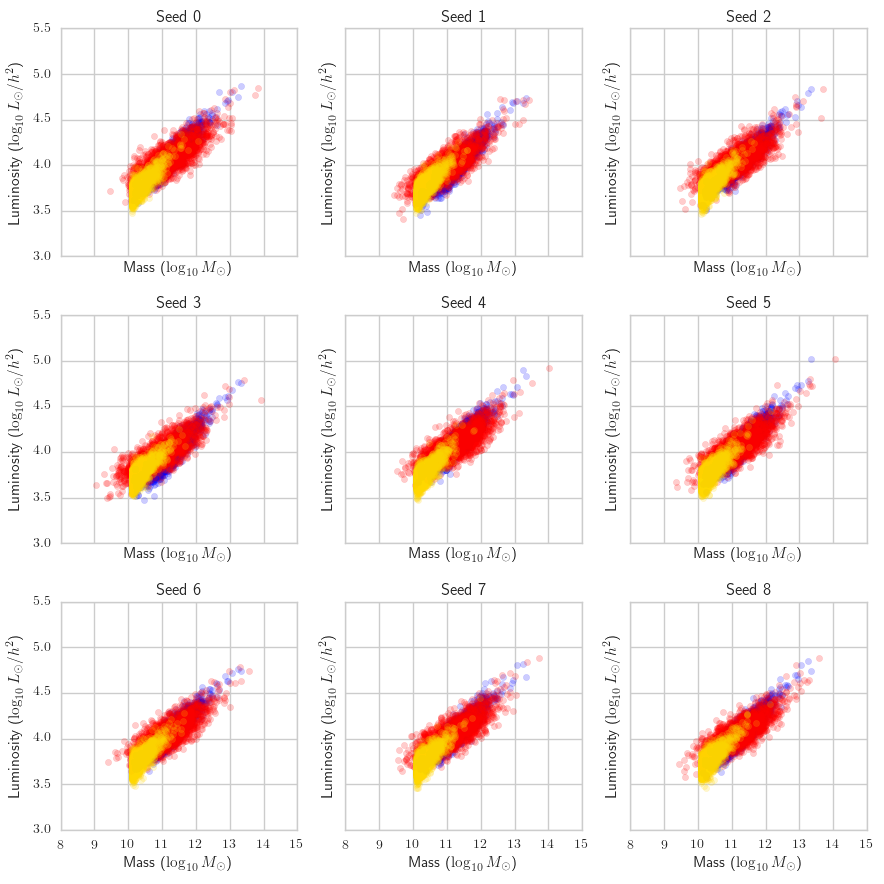

In [13]:
for d in datasets:
    fixed_seed = 0
    alpha1 = datasets[fixed_seed]['alpha1']
    alpha2 = datasets[fixed_seed]['alpha2']
    alpha3 = datasets[fixed_seed]['alpha3']
    alpha4 = datasets[fixed_seed]['alpha4']
    S = datasets[fixed_seed]['S'] * 5 # here is where we multiply by five now
    d['5S_seed_inv_mass_mu'] = alpha3 * (d['inv_lum'] / (np.exp(alpha1) * (1 + d['z']) ** alpha4)) ** (1 / alpha2)
    d['5S_seed_inv_mass'] = lognorm(S, scale=d['seed_inv_mass_mu']).rvs()

f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    s = samplings[i]
    ax.scatter(log10(d['mass']), log10(d['lum']), color='blue', alpha=0.2)
    ax.scatter(log10(d['5S_seed_inv_mass']), log10(d['inv_lum']), color='red', alpha=0.2)
    ax.scatter(log10(s['mass']), log10(s['lum']), color='gold', alpha=0.2)
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Luminosity ($\log_{10} L_{\odot} / h^2$)')
    ax.set_title('Seed %d' % i)

f.tight_layout()

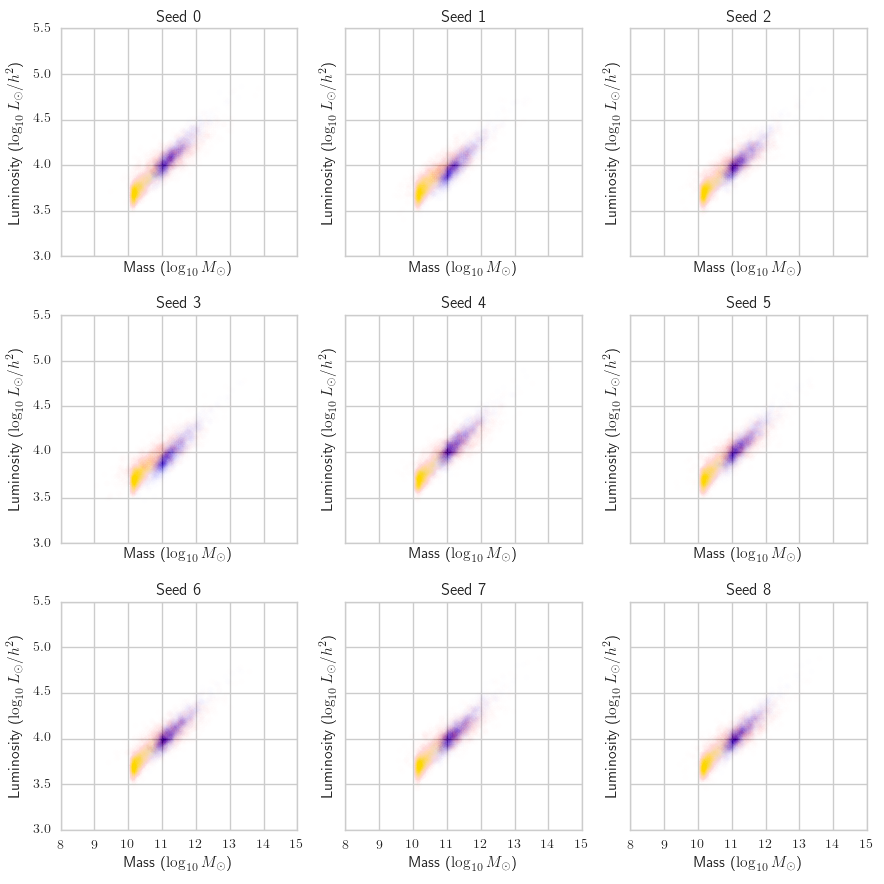

In [14]:
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    d = datasets[i]
    s = samplings[i]
    ax.scatter(log10(d['mass']), log10(d['lum']), color='blue', alpha=0.005)
    ax.scatter(log10(d['5S_seed_inv_mass']), log10(d['inv_lum']), color='red', alpha=0.005)
    ax.scatter(log10(s['mass']), log10(s['lum']), color='gold', alpha=0.005)
    ax.set_xlabel('Mass ($\log_{10} M_{\odot}$)')
    ax.set_ylabel('Luminosity ($\log_{10} L_{\odot} / h^2$)')
    ax.set_title('Seed %d' % i)

f.tight_layout()

# Likelihood

In [15]:
datasets[0]

{'5S_seed_inv_mass': array([  7.78150118e+10,   4.31018467e+10,   5.52431288e+11, ...,
          3.85396347e+11,   4.89164153e+11,   4.17188779e+10]),
 '5S_seed_inv_mass_mu': array([  1.31833059e+11,   1.00030288e+11,   4.08829477e+11, ...,
          3.78584920e+11,   4.70035348e+11,   4.48537981e+10]),
 'S': 0.15544244012477371,
 'alpha1': 10.683109434205313,
 'alpha2': 0.35663960042047638,
 'alpha3': 235000000000000.0,
 'alpha4': 1.1508992892798187,
 'inv_lum': array([ 11014.50077314,   9711.29415151,  15971.66183742, ...,
         16036.21454055,  17319.0181332 ,   7274.42658137]),
 'inv_mass': array([  1.09025060e+11,   9.80422069e+10,   5.20196077e+11, ...,
          3.84857031e+11,   4.33442299e+11,   5.18856982e+10]),
 'inv_mass_mu': array([  1.31833059e+11,   1.00030288e+11,   4.08829477e+11, ...,
          3.78584920e+11,   4.70035348e+11,   4.48537981e+10]),
 'lum': array([ 10803.43290746,   9038.46478203,  16248.45859188, ...,
         16219.58683528,  16556.56473075,   8132

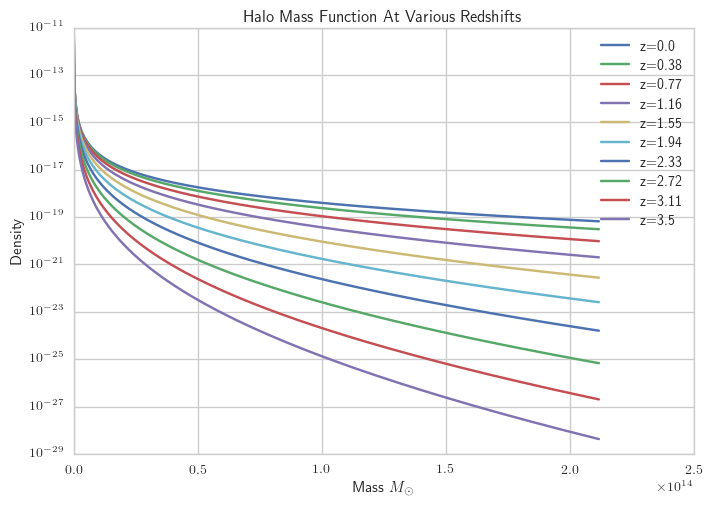

In [16]:
for z in np.linspace(0, 3.5, 10):
    h = 0.73
    Mmin = 10.2358590918
    Mmax = 14.3277327776
    mf = hmf.MassFunction(z=z, Mmin=Mmin, Mmax=Mmax, cosmo_model=hmf.cosmo.WMAP5, hmf_model=hmf.fitting_functions.Tinker10)
    plt.plot(mf.m, mf.dndm, label='z={}'.format(str(z)[:4]))
    plt.ylabel('Density')
    plt.xlabel('Mass $M_{\odot}$')
    plt.gca().set_yscale('log')
    plt.legend()
plt.title('Halo Mass Function At Various Redshifts');

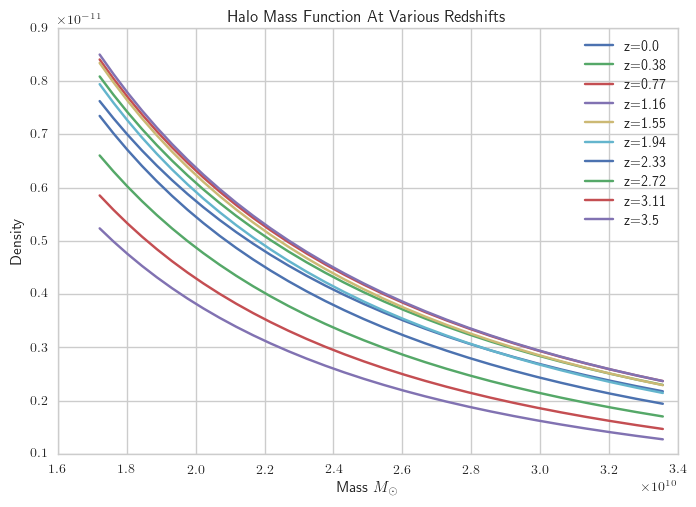

In [17]:
for z in np.linspace(0, 3.5, 10):
    h = 0.73
    Mmin = 10.2358590918
    Mmax = 14.3277327776
    mf = hmf.MassFunction(z=z, Mmin=Mmin, Mmax=Mmax, cosmo_model=hmf.cosmo.WMAP5, hmf_model=hmf.fitting_functions.Tinker10)
    n = 30
    plt.plot(mf.m[:n], mf.dndm[:n], label='z={}'.format(str(z)[:4]))
    plt.ylabel('Density')
    plt.xlabel('Mass $M_{\odot}$')
    plt.legend()
plt.title('Halo Mass Function At Various Redshifts');

In [18]:
import hmf
import scipy.interpolate as interpolate
import pandas as pd
import numpy as np
from scipy.stats import lognorm, norm


class Grid():
    """
    Manages redshift bins.
    """

    def __init__(self, mmin=0, mmax=3.5, nbins=20):
        self.redshifts = np.linspace(mmin, mmax, nbins)
        self.nbins = nbins

    def snap(self, z):
        ind = np.minimum(self.nbins - 1, np.searchsorted(self.redshifts, z))
        return self.redshifts[ind]


class MassPrior():
    """
    Class to represent mass prior distribution.
    Initialize with mass and probability arrays.
    Can both evaluate and sample from distribution.
    """

    def __init__(self, mass, prob):
        self.mass = mass
        self.prob = prob
        self.min = mass.min()
        self.max = mass.max()
        # have to add 0,1 samples for interpolation bounds
        cumsum = np.append(np.append(np.array([0]), np.cumsum(prob)), np.array([1]))
        masses = np.append(np.append(np.array([self.min - 1]), self.mass), np.array([self.max + 1]))
        self.inv_cdf = interpolate.interp1d(cumsum, masses)

    def pdf(self, mass):
        ret = self._pdf(mass)
        if (len(mass) > 1):
            ret = np.prod(ret)
        return ret

    def logpdf(self, mass):
        ret = np.log(self._pdf(mass))
        if (len(mass) > 1):
            ret = np.sum(ret)
        return ret

    def _pdf(self, mass):
        if np.any(mass < self.min) or np.any(mass > self.max):
            raise Exception('out of range')
        right_ind = np.searchsorted(self.mass, mass)
        left_ind = right_ind - 1
        # find where we fall in interval between masses
        f = (mass - self.mass[left_ind]) / (self.mass[right_ind] - self.mass[left_ind])
        return f * self.prob[right_ind] + (1 - f) * self.prob[left_ind]

    def rvs(self, size=1):
        return self.inv_cdf(np.random.rand(size))


class TinkerPrior():
    def __init__(self, grid, h = 0.73, Mmin = 10.2358590918, Mmax = 14.3277327776):
        self.grid = grid
        self.grid_to_prior = dict()
        for z in grid.redshifts:
            mf = hmf.MassFunction(z=z, Mmin=Mmin, Mmax=Mmax, \
                                  cosmo_model=hmf.cosmo.WMAP5, \
                                  hmf_model=hmf.fitting_functions.Tinker10)
            self.grid_to_prior[z] = MassPrior(mf.m * h, mf.dndm / sum(mf.dndm))

    def fetch(self, z):
        return self.grid_to_prior[self.grid.snap(z)]

    def pdf(self, mass, z):
        ret = self.fetch(z)._pdf(mass)
        if (len(mass) > 1):
            ret = np.prod(ret)
        return ret

    def logpdf(self, mass, z):
        ret = np.log(self.fetch(z)._pdf(mass))
        if (len(mass) > 1):
            ret = np.sum(ret)
        return ret

    def rvs(self, z, size=1):
        return self.fetch(z).inv_cdf(np.random.rand(size))


class DataSamples():
    def __init__(self, grid, mass, lum, z):
        self.grid = grid
        grid_to_masses = dict()
        grid_to_luminosities = dict()
        snapzs = grid.snap(z)
        for snapz in grid.redshifts:
            grid_to_masses[snapz] = []
            grid_to_luminosities[snapz] = []
        for i in xrange(len(mass)):
            grid_to_masses[snapzs[i]].append(mass[i])
            grid_to_luminosities[snapzs[i]].append(lum[i])
        self.grid_to_samples = dict()
        for snapz in grid.redshifts:
            self.grid_to_samples[snapz] = np.array([grid_to_masses[snapz], \
                                                    grid_to_luminosities[snapz]]) \
                                                    .transpose()

    def get_mass(self, z):
        snapz = self.grid.snap(z)
        return self.grid_to_samples[snapz][:, 0]

    def get_lum(self, z):
        snapz = self.grid.snap(z)
        return self.grid_to_samples[snapz][:, 1]


class LikelihoodTest():
    def __init__(self, grid, prior, samples, lum_obs, z):
        self.grid = grid
        self.prior = prior
        self.samples = samples
        self.lum_obs = lum_obs
        self.z = z
        self.snapz = grid.snap(z)
        self.sigma_L = 0.05

    def true_log_likelihood(self, alpha1, alpha2, alpha3, alpha4, S):
        ret = 0
        for i in xrange(len(self.lum_obs)):
            if i % 1000 == 0:
                print i
            # 2d integral (mass, lum)
            lum_obs = self.lum_obs[i]
            n = len(lum_obs)
            if n == 0:
                continue
            snapz = self.snapz[i]
            mass = self.samples.get_mass(snapz)
            lum_mu = np.exp(alpha1) * ((mass / alpha3) ** alpha2) * ((1 + snapz) ** alpha4)
            lum = lognorm(S, scale=lum_mu).rvs(n)
            val = np.sum(lognorm(self.sigma_L, scale=lum).pdf(lum_obs))
            ret += np.log(val) - np.log(n)
        return ret

    def naive_log_likelihood(self, alpha1, alpha2, alpha3, alpha4, S):
        raise NotImplemented()

    def importance_sampling_log_likelihood(self, alpha1, alpha2, alpha3, alpha4, S):
        raise NotImplemented()


# test
np.random.seed(0)
alpha1 = norm(10.709, 0.022).rvs()
alpha2 = norm(0.359, 0.009).rvs()
alpha3 = 2.35e14
alpha4 = norm(1.10, 0.06).rvs()
S = norm(0.155, 0.0009).rvs()
data = pd.read_csv('/Users/user/Code/PanglossNotebooks/MassLuminosityProject/mock_data.csv')
grid = Grid()
prior = TinkerPrior(grid)
samples = DataSamples(grid, data.mass.as_matrix(), data.lum.as_matrix(), data.z.as_matrix())
# test = LikelihoodTest(grid, prior, samples, data.lum_obs.as_matrix(), data.z.as_matrix())
# test.true_log_likelihood(alpha1, alpha2, alpha3, alpha4, S)

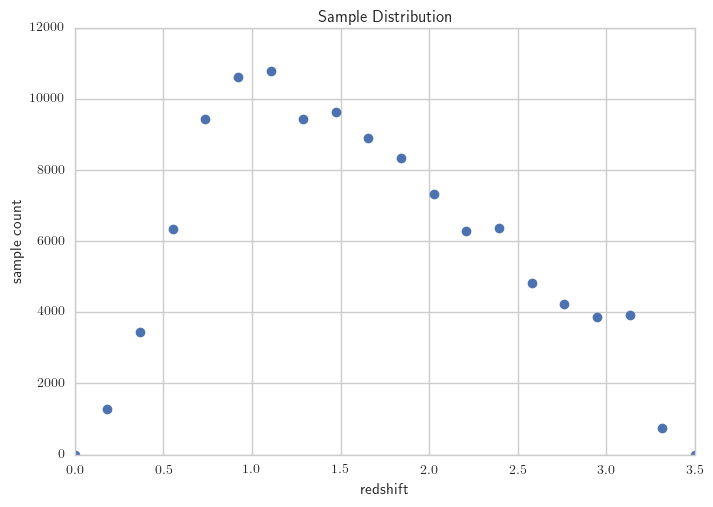

In [19]:
keys = np.sort(samples.grid_to_samples.keys())
counts = map(lambda k: samples.grid_to_samples[k].shape[0], keys)
plt.plot(keys, counts, 'o')
plt.xlabel('redshift')
plt.ylabel('sample count')
plt.title('Sample Distribution');

### True Likelihood Calculation

The likelihood under hyperparameters H for a single galaxy is 

$$\iint P(L_{obs}|L)P(L|M,z,H),P(M|z)dMdL$$ 

We can generate M-L samples from P(L|M,z,H),P(M|z). We use the true mass samples at fixed redshift and generate luminosities for each one. Lets call the set of these M-L samples $T(z,H)$, since the samples are a dependent on z and H. Then we use monte-carlo integration

$$\iint P(L_{obs}|L)dP(L,M|z,H) \sim \frac{1}{N_T} \sum_{M,L,L_{obs} \sim T(z,H)} P(L_{obs}|L)$$

Generalizing this for each galaxy in G we have

$$\mathcal{L} \sim \prod_{g \in G} \left[\frac{1}{N_{T(z^g,H)}} \sum_{M^g,L^g,L_{obs}^g \sim T(z^g,H)} P(L_{obs}^g|L^g) \right]$$

and taking the log

$$\mathcal{l} \sim \sum_{g \in G} -\log({N_{T(z^g,H)}}) + \log\left[ \sum_{M^g,L^g,L_{obs}^g \sim T(z^g,H)} P(L_{obs}^g|L^g) \right]$$

... but then we never use 'true' L samples - gues this is ok.


### Naive Likelihood Calculation

The only difference is the sampling distribution, specifically how we sample mass. Now we draw mass from the tinker prior. Let $N(z^g,H)$ denote this sampling. Then we have 

$$\mathcal{l} \sim \sum_{g \in G} -\log({N_{N(z^g,H)}}) + \log\left[ \sum_{M^g,L^g,L_{obs}^g \sim N(z^g,H)} P(L_{obs}^g|L^g) \right]$$

### Importance Sampling Likelihood Calculation

Now we draw M-L tuples from a biased distribution which we must be able to evaluate $Q(M^g,L^g,L_{obs}^g,z^g,H)$ and generate samples $B(z^g,H)$ from. Then we have

$$\mathcal{l} \sim \sum_{g \in G} -\log({N_{B(z^g,H)}}) + \log\left[ \sum_{M^g,L^g,z^g,L_{obs}^g \sim B(z^g,H)} \frac{P(L_{obs}^g|L^g)P(L^g|M^g,z^g,H)P(M^g|z^g)}{Q(M^g,L^g,L_{obs}^g,z^g,H)} \right]$$

### Performance Improvement

Compute samples and weights for each redshift bin, then only thing that changes between galaxies in a bin is $P(L^g_{obs}|L^g)$. Iterate through one redshift bin at a time. This will reduce computation by factor of 2 (see exp below).

$$\mathcal{l} \sim \sum_{g \in G} -\log({N_{T(z^g,H)}}) + \log\left[ \sum_{M^g,L^g,L_{obs}^g \sim T(z^g,H)} P(L_{obs}^g|L^g) \right]$$

In [20]:
mass = data.mass
snapz = 10
lum_obs = data.lum_obs
%time lum_mu = np.exp(alpha1) * ((mass / alpha3) ** alpha2) * ((1 + snapz) ** alpha4)
%time lum = lognorm(S, scale=lum_mu).rvs()
%time val = lognorm(0.05, scale=lum).pdf(lum_obs)

CPU times: user 11.1 ms, sys: 4.64 ms, total: 15.8 ms
Wall time: 15.6 ms
CPU times: user 8.7 ms, sys: 455 µs, total: 9.16 ms
Wall time: 8.8 ms
CPU times: user 15.8 ms, sys: 2.69 ms, total: 18.5 ms
Wall time: 18.8 ms


In [21]:
%time dist = lognorm(0.05, scale=lum)
%time val = dist.pdf(lum_obs);

CPU times: user 1.78 ms, sys: 442 µs, total: 2.22 ms
Wall time: 1.82 ms
CPU times: user 29.1 ms, sys: 4.03 ms, total: 33.2 ms
Wall time: 33.7 ms


In [22]:
%time dist = norm(lum)
%time val = dist.pdf(lum_obs);

CPU times: user 1.37 ms, sys: 58 µs, total: 1.42 ms
Wall time: 1.58 ms
CPU times: user 11.9 ms, sys: 2.36 ms, total: 14.3 ms
Wall time: 13.4 ms


In [23]:
%time val = lum_obs * lum_obs

CPU times: user 953 µs, sys: 469 µs, total: 1.42 ms
Wall time: 1.06 ms


In [29]:
import numpy as np
from numba import jit

a = np.random.rand(10 ** 6)
b = np.random.rand(10 ** 6)
c = np.random.rand(10 ** 6)

@jit
def foo(x):
    

def fool(x):
    tmp = b + x 
    tmp2 = tmp ** 2
    return tmp2

%time x = fool(c);
%time y = foo(c);

CPU times: user 5.35 ms, sys: 4.71 ms, total: 10.1 ms
Wall time: 11 ms
CPU times: user 173 ms, sys: 7.28 ms, total: 180 ms
Wall time: 183 ms


Motivation for using numba:

In [37]:
import numpy as np
from numba import jit
nobs = 10 ** 7

def proc_numpy(x,y,z):

   x = x*2 - ( y * 55 )      # these 4 lines represent use cases
   y = x + y*2               # where the processing time is mostly
   z = x + y + 99            # a function of, say, 50 to 200 lines
   z = z * ( z - .88 )       # of fairly simple numerical operations

   return z

@jit(nogil=True, nopython=True, cache=True)
def proc_numba(xx,yy,zz):
   for j in range(nobs):     # as pointed out by Llopis, this for loop 
      x, y = xx[j], yy[j]    # is not needed here.  it is here by 
                             # accident because in the original benchmarks 
      x = x*2 - ( y * 55 )   # I was doing data creation inside the function 
      y = x + y*2            # instead of passing it in as an array
      z = x + y + 99         # in any case, this redundant code seems to 
      z = z * ( z - .88 )    # have something to do with the code running
                             # faster.  without the redundant code, the 
      zz[j] = z              # numba and numpy functions are exactly the same.
   return zz

x = np.random.randn(nobs)
y = np.random.randn(nobs)
z = np.zeros(nobs)
%time res_numpy = proc_numpy(x,y,z)

z = np.zeros(nobs)
%time res_numba = proc_numba(x,y,z)

CPU times: user 171 ms, sys: 105 ms, total: 277 ms
Wall time: 277 ms
CPU times: user 21.1 ms, sys: 8.01 ms, total: 29.1 ms
Wall time: 29.7 ms


This is why I am holding off from using logsumexp for now:

In [111]:
from scipy.misc import logsumexp

for i in xrange(8):
    r = np.random.rand(10**i)
    print i
    %time tmp = np.log(np.sum(r))
    %time tmp = logsumexp(np.log(r));
    %time tmp = np.log(np.sum(np.exp(np.log(r))))

0
CPU times: user 61 µs, sys: 7 µs, total: 68 µs
Wall time: 70.1 µs
CPU times: user 159 µs, sys: 42 µs, total: 201 µs
Wall time: 193 µs
CPU times: user 65 µs, sys: 0 ns, total: 65 µs
Wall time: 73 µs
1
CPU times: user 50 µs, sys: 0 ns, total: 50 µs
Wall time: 57 µs
CPU times: user 174 µs, sys: 42 µs, total: 216 µs
Wall time: 223 µs
CPU times: user 53 µs, sys: 1e+03 ns, total: 54 µs
Wall time: 59.8 µs
2
CPU times: user 37 µs, sys: 1 µs, total: 38 µs
Wall time: 47.9 µs
CPU times: user 167 µs, sys: 59 µs, total: 226 µs
Wall time: 213 µs
CPU times: user 56 µs, sys: 3 µs, total: 59 µs
Wall time: 66 µs
3
CPU times: user 52 µs, sys: 35 µs, total: 87 µs
Wall time: 51 µs
CPU times: user 317 µs, sys: 77 µs, total: 394 µs
Wall time: 338 µs
CPU times: user 54 µs, sys: 1e+03 ns, total: 55 µs
Wall time: 57.9 µs
4
CPU times: user 33 µs, sys: 1e+03 ns, total: 34 µs
Wall time: 37 µs
CPU times: user 359 µs, sys: 240 µs, total: 599 µs
Wall time: 605 µs
CPU times: user 224 µs, sys: 0 ns, total: 224 µs
Wal

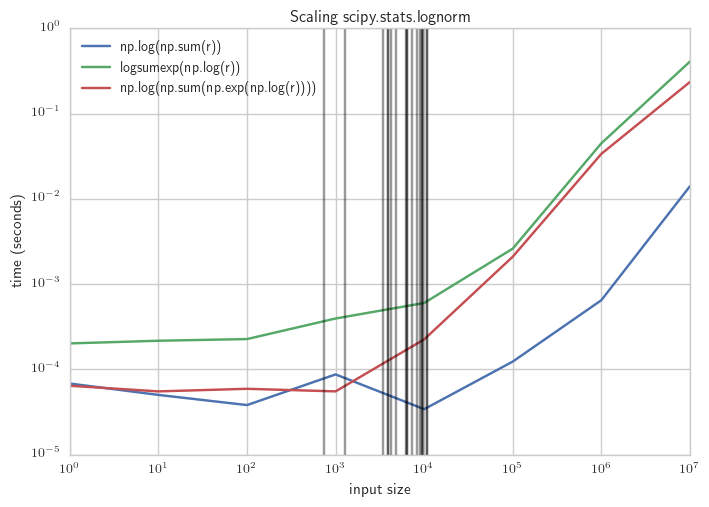

In [121]:
times1 = [68e-6, 50e-6, 38e-6, 87e-6, 34e-6, 123e-6, 645e-6, 14e-3]
times2 = [201e-6, 216e-6, 226e-6, 394e-6, 599e-6, 2.6e-3, 44.7e-3, 406e-3]
times3 = [64e-6, 55e-6, 59e-6, 55e-6, 224e-6, 2.09e-3, 33.6e-3, 234e-3]
size = map(lambda x : 10**x , range(8))
plt.plot(size, times1, label='np.log(np.sum(r))')
plt.plot(size, times2, label='logsumexp(np.log(r))')
plt.plot(size, times3, label='np.log(np.sum(np.exp(np.log(r))))')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlabel('input size')
plt.ylabel('time (seconds)')
for i in xrange(len(counts)):
    if counts[i] < 1:
        continue
    plt.gca().axvline(counts[i], color='k', alpha=0.4)
plt.legend(loc=2)
plt.title('Scaling scipy.stats.lognorm');

# Numba jit

Not seeing any performance improvement with the following:

~~~~ 
    @jit(nogil=True, cache=True)
    def true_log_likelihood(self, alpha1, alpha2, alpha3, alpha4, S):
        ret = 0
        for i in xrange(len(self.lum_obs)):
            # if i % 1000 == 0:
                # print i
            # 2d integral (mass, lum)
            lum_obs = self.lum_obs[i]
            snapz = self.snapz[i]
            mass = self.samples.get_mass(snapz)
            n = len(mass)
            lum_mu = np.exp(alpha1) * ((mass / alpha3) ** alpha2) * ((1 + snapz) ** alpha4)
            lum = lognorm(S, scale=lum_mu).rvs(n)
            val = np.sum(lognorm(self.sigma_L, scale=lum).pdf(lum_obs))
            ret += np.log(val) - np.log(n)
        return ret
~~~~

This is largely because this block depends on python objects from numpy, scipy and so numba compiles in object mode as opposed to the much faster 'nopython' mode.

# First Profiling

~~~~
Timer unit: 1e-06 s

Total time: 9.74685 s
File: /Users/user/Code/Scratch/first_likelihood.py
Function: true_log_likelihood at line 131

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
   131                                               @profile
   132                                               def true_log_likelihood(self, alpha1, alpha2, alpha3, alpha4, S):
   133         1            2      2.0      0.0          ret = 0
   134      4001         3511      0.9      0.0          for i in xrange(4*10**3):#len(self.lum_obs)):
   135      4000         6118      1.5      0.1              lum_obs = self.lum_obs[i]
   136      4000         3570      0.9      0.0              snapz = self.snapz[i]
   137      4000        61314     15.3      0.6              lum = self.samples.get_lum(snapz)
   138      4000      9638661   2409.7     98.9              val = np.sum(lognorm(self.sigma_L, scale=lum).pdf(lum_obs))
   139      4000        33671      8.4      0.3              ret += np.log(val) - np.log(len(lum))
   140         1            0      0.0      0.0          return ret
~~~~

We are spending most of our time in the lognormal pdf evaluation. Below I show that the lognormal pdf evaluation is fairly well vectorized by showing that the ratio of runtimes of array addition and lognormal pdf evaluation (96) is about the same as the ratio of runtimes of single number addition and lognormal pdf evaluation (80).

In [81]:
a = np.random.rand(10 ** 7)

%time dist = lognorm(0.5, scale=a)
%time dist.pdf(0.5)
%time a + a

CPU times: user 979 µs, sys: 12.7 ms, total: 13.6 ms
Wall time: 13.6 ms
CPU times: user 1.22 s, sys: 510 ms, total: 1.74 s
Wall time: 1.85 s
CPU times: user 16.8 ms, sys: 5.25 ms, total: 22 ms
Wall time: 21.9 ms


array([ 1.74457168,  1.82738066,  1.13840978, ...,  1.87840079,
        0.10759749,  0.92442798])

In [73]:
%time dist = lognorm(0.5, 0.5)
%time dist.pdf(0.5)
%time 0.5 + 0.5

CPU times: user 1.3 ms, sys: 300 µs, total: 1.6 ms
Wall time: 1.4 ms
CPU times: user 139 µs, sys: 21 µs, total: 160 µs
Wall time: 148 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs


1.0

In [77]:
160/2

80

In [76]:
(2.04 / 21.1) * 10 ** 3

96.6824644549763

Next I tried significantly lowering the samples per redshift bin. I brought them down from there true values (approx $10^3-10^4$, see plot above) to 10. When I reran the code I only saw a performance improvement by a factor of $\textbf{2}$! Line profiling confirms that over 98% of the time is still spent in scipy.stats.lognormal.

~~~~
Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
   131                                               @profile
   132                                               def true_log_likelihood(self, alpha1, alpha2, alpha3, alpha4, S):
   133         1            2      2.0      0.0          ret = 0
   134     40001        34984      0.9      0.0          for i in xrange(40*10**3):#len(self.lum_obs)):
   135     40000        60362      1.5      0.1              lum_obs = self.lum_obs[i]
   136     40000        34534      0.9      0.0              snapz = self.snapz[i]
   137     40000       578745     14.5      0.8              lum = self.samples.get_lum(snapz)
   138     40000        41626      1.0      0.1              if len(lum) == 0:
   139                                                           continue
   140     40000        50288      1.3      0.1              lum = lum[:10]
   141     40000     70418865   1760.5     98.5              val = np.sum(lognorm(self.sigma_L, scale=lum).pdf(lum_obs))
   142     40000       300340      7.5      0.4              ret += np.log(val) - np.log(len(lum))
   143         1            1      1.0      0.0          return ret
~~~~

Next we time lognorm evaluations with different input sizes and plot them below. We also plot the redshift bin sizes to show that we cannot squeeze out much performance by shrinking the bin size. This is still consistent with the ratio test above because there we compared to input size of $10^7$ where we start to see linear scaling.

In [82]:
for i in xrange(8):
    a = np.random.rand(10 ** i)
    dist = lognorm(0.5, scale=a)
    print i
    %time dist.pdf(0.5) 

0
CPU times: user 437 µs, sys: 228 µs, total: 665 µs
Wall time: 551 µs
1
CPU times: user 485 µs, sys: 260 µs, total: 745 µs
Wall time: 588 µs
2
CPU times: user 298 µs, sys: 38 µs, total: 336 µs
Wall time: 341 µs
3
CPU times: user 430 µs, sys: 94 µs, total: 524 µs
Wall time: 532 µs
4
CPU times: user 1.47 ms, sys: 868 µs, total: 2.34 ms
Wall time: 2.35 ms
5
CPU times: user 11.9 ms, sys: 40.5 ms, total: 52.5 ms
Wall time: 53.5 ms
6
CPU times: user 165 ms, sys: 107 ms, total: 272 ms
Wall time: 274 ms
7
CPU times: user 1.51 s, sys: 920 ms, total: 2.43 s
Wall time: 2.73 s


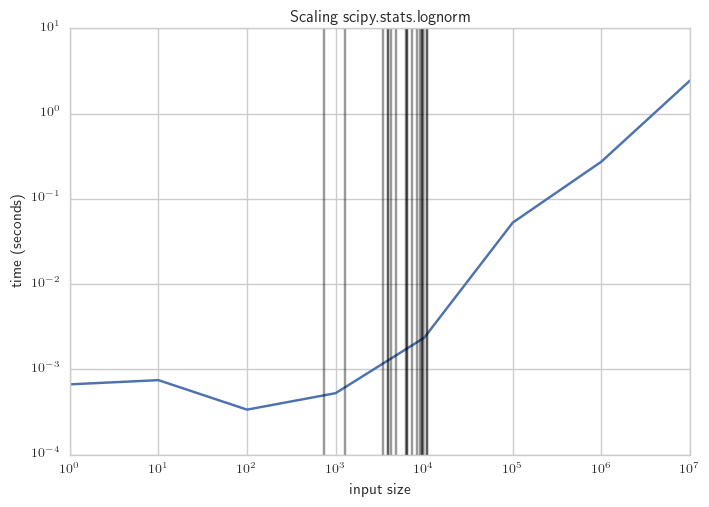

In [102]:
times = [665e-6, 745e-6, 336e-6, 524e-6, 2.34e-3, 52.5e-3, 272e-3, 2.43]
size = map(lambda x : 10**x , range(8))
plt.plot(size, times)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlabel('input size')
plt.ylabel('time (seconds)')
for i in xrange(len(counts)):
    if counts[i] < 1:
        continue
    plt.gca().axvline(counts[i], color='k', alpha=0.4)
plt.title('Scaling scipy.stats.lognorm');

In [123]:
print 'abridged back of the envelope runtime: {} minutes'.format((745e-6 * len(lum_obs) / 60))
print 'standard back of the envelope runtime: {} minutes'.format((2.34e-3 * len(lum_obs) / 60))

abridged back of the envelope runtime: 1.43932758333 minutes
standard back of the envelope runtime: 4.520841 minutes


In [155]:
print 'abridged runtime: {} minutes'.format(140.984743834 / 60)
print 'runtime: {} minutes'.format(268.072308064 / 60)

abridged runtime: 2.34974573057 minutes
runtime: 4.46787180107 minutes


We also end up with -inf answers suggesting that we may need to use logexpsum despite its poor performance.

# Manual Lognorm

In [150]:
class LogNorm():
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def pdf(self, x):
        return (1 / (x * self.sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((np.log(x) - np.log(self.mu)) ** 2 / self.sigma ** 2))

In [131]:
for i in xrange(8):
    a = np.random.rand(10 ** i)
    dist = LogNorm(0.5, a)
    %time dist.pdf(0.5) 

CPU times: user 65 µs, sys: 50 µs, total: 115 µs
Wall time: 119 µs
CPU times: user 71 µs, sys: 15 µs, total: 86 µs
Wall time: 84.9 µs
CPU times: user 103 µs, sys: 28 µs, total: 131 µs
Wall time: 138 µs
CPU times: user 59 µs, sys: 1e+03 ns, total: 60 µs
Wall time: 63.9 µs
CPU times: user 211 µs, sys: 207 µs, total: 418 µs
Wall time: 425 µs
CPU times: user 1.74 ms, sys: 597 µs, total: 2.34 ms
Wall time: 2.42 ms
CPU times: user 25.1 ms, sys: 17.9 ms, total: 43 ms
Wall time: 45.7 ms
CPU times: user 224 ms, sys: 148 ms, total: 372 ms
Wall time: 439 ms


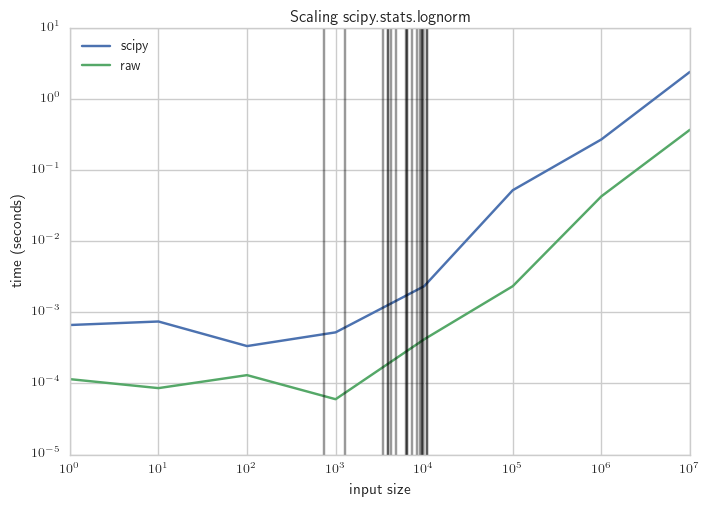

In [166]:
times1 = [665e-6, 745e-6, 336e-6, 524e-6, 2.34e-3, 52.5e-3, 272e-3, 2.43]
times2 = [115e-6, 86e-6, 131e-6, 60e-6, 418e-6, 2.34e-3, 43e-3, 372e-3]
size = map(lambda x : 10**x , range(8))
plt.plot(size, times1, label='scipy')
plt.plot(size, times2, label='raw')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlabel('input size')
plt.ylabel('time (seconds)')
for i in xrange(len(counts)):
    if counts[i] < 1:
        continue
    plt.gca().axvline(counts[i], color='k', alpha=0.4)
plt.legend(loc=2)
plt.title('Scaling scipy.stats.lognorm');

In [153]:
#confirm same
print LogNorm(10,1).pdf(10)
print lognorm(1,scale=10).pdf(10)

0.0398942280401
0.0398942280401


# WOOHOO - under a minute!

After making this change the runtime has accelerated dramatically.

In [157]:
print 'new abridged runtime: {} minutes'.format(5.14367508888 / 60)
print 'new runtime: {} minutes'.format(26.4348368645 / 60)

new abridged runtime: 0.085727918148 minutes
new runtime: 0.440580614408 minutes


New profile below:

~~~~
Total time: 27.1258 s
File: /Users/user/Code/Scratch/first_likelihood.py
Function: true_log_likelihood at line 135

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
   135                                               @profile
   136                                               def true_log_likelihood(self, alpha1, alpha2, alpha3, alpha4, S):
   137         1            3      3.0      0.0          ret = 0
   138    115920        75309      0.6      0.3          for i in xrange(len(self.lum_obs)):
   139    115919       118972      1.0      0.4              lum_obs = self.lum_obs[i]
   140    115919        86693      0.7      0.3              snapz = self.snapz[i]
   141    115919      1133916      9.8      4.2              lum = self.samples.get_lum(snapz)
   142    115919       105045      0.9      0.4              if len(lum) == 0:
   143                                                           continue
   144    115919     24918347    215.0     91.9              val = np.sum(lognorm_eval(lum, self.sigma_L, lum_obs))
   145    115919       687488      5.9      2.5              ret += np.log(val) - np.log(len(lum))
   146         1            0      0.0      0.0          return ret
   ~~~~

Now we try with scipy.misc.logsumexp and lognorm_log_eval. Result is the exact same (-1096670.13887) but the logsumexp version is a bit slower.

~~~~
Total time: 40.8048 s
File: /Users/user/Code/Scratch/first_likelihood.py
Function: true_log_likelihood at line 141

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
   141                                               @profile
   142                                               def true_log_likelihood(self, alpha1, alpha2, alpha3, alpha4, S):
   143         1            3      3.0      0.0          ret = 0
   144    115920        94799      0.8      0.2          for i in xrange(len(self.lum_obs)):
   145    115919       152595      1.3      0.4              lum_obs = self.lum_obs[i]
   146    115919        99825      0.9      0.2              snapz = self.snapz[i]
   147    115919      1496449     12.9      3.7              lum = self.samples.get_lum(snapz)
   148    115919       116669      1.0      0.3              if len(lum) == 0:
   149                                                           continue
   150    115919     38199989    329.5     93.6              val = logsumexp(lognorm_log_eval(lum, self.sigma_L, lum_obs))
   151    115919       644478      5.6      1.6              ret += val - np.log(len(lum))
   152         1            1      1.0      0.0          return ret
~~~~

# Confirm some posterior values

In [171]:
import hmf
import scipy.interpolate as interpolate
import pandas as pd
import numpy as np
from scipy.stats import lognorm, norm
from scipy.misc import logsumexp


class Grid():
    """
    Manages redshift bins.
    """

    def __init__(self, mmin=0, mmax=3.5, nbins=20):
        self.redshifts = np.linspace(mmin, mmax, nbins)
        self.nbins = nbins

    def snap(self, z):
        ind = np.minimum(self.nbins - 1, np.searchsorted(self.redshifts, z))
        return self.redshifts[ind]


class MassPrior():
    """
    Class to represent mass prior distribution.
    Initialize with mass and probability arrays.
    Can both evaluate and sample from distribution.
    """

    def __init__(self, mass, prob):
        self.mass = mass
        self.prob = prob
        self.min = mass.min()
        self.max = mass.max()
        # have to add 0,1 samples for interpolation bounds
        cumsum = np.append(np.append(np.array([0]), np.cumsum(prob)), np.array([1]))
        masses = np.append(np.append(np.array([self.min - 1]), self.mass), np.array([self.max + 1]))
        self.inv_cdf = interpolate.interp1d(cumsum, masses)

    def pdf(self, mass):
        ret = self._pdf(mass)
        if (len(mass) > 1):
            ret = np.prod(ret)
        return ret

    def logpdf(self, mass):
        ret = np.log(self._pdf(mass))
        if (len(mass) > 1):
            ret = np.sum(ret)
        return ret

    def _pdf(self, mass):
        if np.any(mass < self.min) or np.any(mass > self.max):
            raise Exception('out of range')
        right_ind = np.searchsorted(self.mass, mass)
        left_ind = right_ind - 1
        # find where we fall in interval between masses
        f = (mass - self.mass[left_ind]) / (self.mass[right_ind] - self.mass[left_ind])
        return f * self.prob[right_ind] + (1 - f) * self.prob[left_ind]

    def rvs(self, size=1):
        return self.inv_cdf(np.random.rand(size))


class TinkerPrior():
    def __init__(self, grid, h = 0.73, Mmin = 10.2358590918, Mmax = 14.3277327776):
        self.grid = grid
        self.grid_to_prior = dict()
        for z in grid.redshifts:
            mf = hmf.MassFunction(z=z, Mmin=Mmin, Mmax=Mmax, \
                                  cosmo_model=hmf.cosmo.WMAP5, \
                                  hmf_model=hmf.fitting_functions.Tinker10)
            self.grid_to_prior[z] = MassPrior(mf.m * h, mf.dndm / sum(mf.dndm))

    def fetch(self, z):
        return self.grid_to_prior[self.grid.snap(z)]

    def pdf(self, mass, z):
        ret = self.fetch(z)._pdf(mass)
        if (len(mass) > 1):
            ret = np.prod(ret)
        return ret

    def logpdf(self, mass, z):
        ret = np.log(self.fetch(z)._pdf(mass))
        if (len(mass) > 1):
            ret = np.sum(ret)
        return ret

    def rvs(self, z, size=1):
        return self.fetch(z).inv_cdf(np.random.rand(size))


class DataSamples():
    def __init__(self, grid, mass, lum, z):
        self.grid = grid
        grid_to_masses = dict()
        grid_to_luminosities = dict()
        snapzs = grid.snap(z)
        for snapz in grid.redshifts:
            grid_to_masses[snapz] = []
            grid_to_luminosities[snapz] = []
        for i in xrange(len(mass)):
            grid_to_masses[snapzs[i]].append(mass[i])
            grid_to_luminosities[snapzs[i]].append(lum[i])
        self.grid_to_samples = dict()
        for snapz in grid.redshifts:
            self.grid_to_samples[snapz] = np.array([grid_to_masses[snapz], \
                                                    grid_to_luminosities[snapz]]) \
                                                    .transpose()

    def get_mass(self, z):
        snapz = self.grid.snap(z)
        return self.grid_to_samples[snapz][:, 0]

    def get_lum(self, z):
        snapz = self.grid.snap(z)
        return self.grid_to_samples[snapz][:, 1]

def lognorm_eval(mu, sigma, x):
        return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(
                -0.5 * ((np.log(x) - np.log(mu)) ** 2 / sigma ** 2))

def lognorm_log_eval(mu, sigma, x):
    return -np.log(x * sigma * np.sqrt(2 * np.pi)) \
        -0.5 * ((np.log(x) - np.log(mu)) ** 2 / sigma ** 2)

class LikelihoodTest(object):
    def __init__(self, grid, prior, samples, lum_obs, z):
        self.grid = grid
        self.prior = prior
        self.samples = samples
        self.lum_obs = lum_obs
        self.z = z
        self.snapz = grid.snap(z)
        self.sigma_L = 0.05

    def true_log_likelihood(self):
        ret = 0
        for i in xrange(len(self.lum_obs)):
            lum_obs = self.lum_obs[i]
            snapz = self.snapz[i]
            lum = self.samples.get_lum(snapz)
            if len(lum) == 0:
                continue
            val = logsumexp(lognorm_log_eval(lum, self.sigma_L, lum_obs))
            ret += val - np.log(len(lum))
        return ret

    def naive_log_likelihood(self):
        raise NotImplemented()

    def biased_log_likelihood(self, a1, a2, a3, a4, S):
        ret = 0
        for i in xrange(len(self.lum_obs)):
            lum_obs = self.lum_obs[i]
            snapz = self.snapz[i]
            lum = self.samples.get_lum(snapz)
            if len(lum) == 0:
                continue
            val = np.sum(lognorm(self.sigma_L, scale=lum).pdf(lum_obs))
            ret += np.log(val) - np.log(len(lum))
        return ret

In [172]:
data = pd.read_csv('/Users/user/Code/PanglossNotebooks/MassLuminosityProject/mock_data.csv')
grid = Grid()
prior = TinkerPrior(grid)
z = data.z.as_matrix()
lum_obs = data.lum_obs.as_matrix()
mass = data.mass.as_matrix()

for seed in xrange(6): 
    np.random.seed(seed)
    alpha1 = norm(10.709, 0.022).rvs()
    alpha2 = norm(0.359, 0.009).rvs()
    alpha3 = 2.35e14
    alpha4 = norm(1.10, 0.06).rvs()
    S = norm(0.155, 0.0009).rvs()
    S_M = 5.6578015811698101 * S
    sigma_L = 0.05
    mu_lum = np.exp(alpha1) * ((mass / alpha3) ** (alpha2))* ((1+z) ** (alpha4))
    lum = lognorm(S, scale=mu_lum).rvs()
    samples = DataSamples(grid, mass, lum, z)
    test = LikelihoodTest(grid, prior, samples, lum_obs, z)
    log_like = test.true_log_likelihood()
    print 'seed: {}, log-likelihood: {}'.format(seed, log_like)

seed: 0, log-likelihood: -1096670.13887
seed: 1, log-likelihood: -1097789.47894
seed: 2, log-likelihood: -1114243.70689
seed: 3, log-likelihood: -1098390.5981
seed: 4, log-likelihood: -1108175.03118
seed: 5, log-likelihood: -1102744.11707


# TODO
- Build conditional biased disribution (P(M,L|z)) we can evaluate.
- Refactor likelihood code.
- Confirm importance sampling results are sane
- Compare naive and biased convergence rates
- give negative-log-likedlihoods to scipy.minimize and confirm get hyperparameters back

In [183]:
size = 10**6
sigma = .1
mean = 10
%time a = np.random.lognormal(mean=np.log(mean), sigma=sigma, size=size)
%time b = lognorm.rvs(sigma, scale=mean, size=size)

CPU times: user 61.6 ms, sys: 4.63 ms, total: 66.2 ms
Wall time: 65.3 ms
CPU times: user 74.9 ms, sys: 14.2 ms, total: 89 ms
Wall time: 91.9 ms


(array([  9.62000000e+02,   3.28110000e+04,   2.07142000e+05,
          3.80860000e+05,   2.69107000e+05,   8.99250000e+04,
          1.69490000e+04,   2.05000000e+03,   1.87000000e+02,
          7.00000000e+00]),
 array([  6.33964782,   7.33338126,   8.32711469,   9.32084812,
         10.31458156,  11.30831499,  12.30204843,  13.29578186,
         14.2895153 ,  15.28324873,  16.27698217]),
 <a list of 10 Patch objects>)

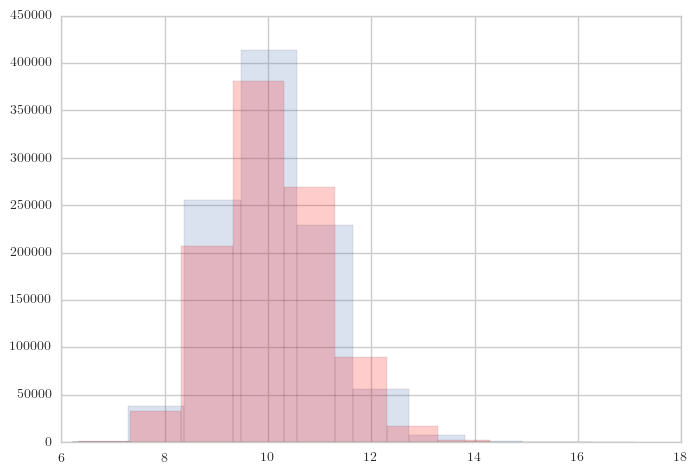

In [184]:
plt.hist(a, alpha=0.2)
plt.hist(b, alpha=0.2, color='red')

In [185]:
a.mean()

10.049573262679974

In [186]:
b.mean()

10.050261635404381